## Preprocessing of volumentric imaging data Volume (motion correction and calculation of DFF in 4D)

In [1]:
from ScanImageTiffReader import ScanImageTiffReader
from matplotlib import pyplot as plt
import numpy as np

#from sys import path
from os.path import sep, exists
from os import mkdir, makedirs, getcwd

import napari
import xarray as xr

from fly2p.viz.viz import myAxisTheme
from fly2p.preproc.scanImageUtils import getSIbasicMetadata, getSIMetadict, loadvolume
import fly2p.preproc.imgPreproc as imp

%gui qt5
%config Completer.use_jedi = False  #magic to fix autocomplete issue

### (1) Load, parse metadata and generate data object
#### Set paths to data files and plot directory

In [3]:
dataDir = '../sample/'
rawTiff = 'SS96-x-7f_EB_sample.tif'
genotype = 'SS96-x-GCaMP7f'
flyID = 'testfly'
trial = 'test'
region = 'ellipsoid body'

saveDir = dataDir
preprocDir = dataDir
# Generate directory where to save plots
if not exists(saveDir): makedirs(saveDir)
if not exists(preprocDir): makedirs(preprocDir)


#### Extract relevant information from header, read and reshape image tiff stack

In [4]:
mytiffreader = ScanImageTiffReader(sep.join([dataDir, rawTiff]))
basicMetadat = getSIbasicMetadata(mytiffreader.metadata())
basicMetadat["CaCh"] = 0 # give channel identity
SImetadict = getSIMetadict(mytiffreader.metadata())

# Load data: With larger file sizes, the scanimage loader fails (idk why)
stack = loadvolume(sep.join([dataDir, rawTiff]), basicMetadat, selectCaChan=True)
imgStack = imp.stack2xarray(stack, basicMetadat)

SI.VERSION_COMMIT = '4a9264c4fccd21a03258704d0d6489537ad79e6c'
SI.VERSION_MAJOR = '2018b'
SI.VERSION_MINOR = '1'


In [5]:
# To debug only: select subset of stack
imgStack = imgStack[500:2000,:,:]

### (2) Perform motion correction
#### Generate reference volume
Check if reference image is good: It should not be to biased by transient activity peaks.

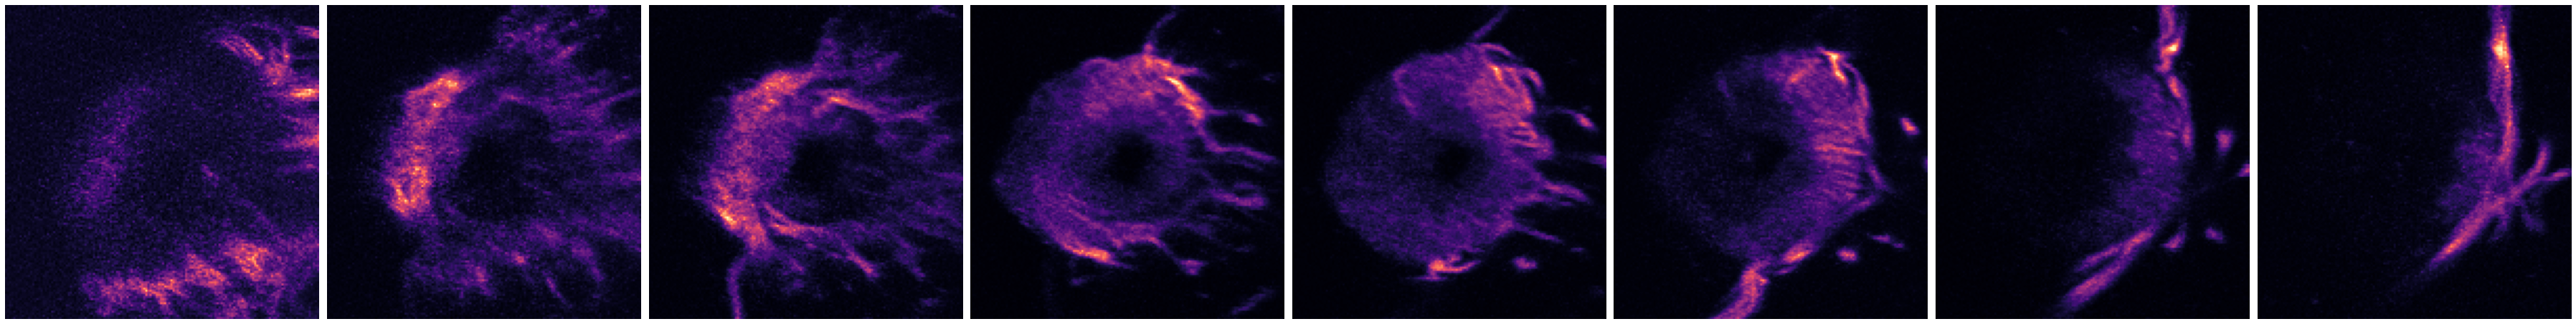

In [6]:
# Make reference volume
numRefImg = 20
refVol = np.mean(imgStack[round(imgStack['volumes [s]'].size/2) :round(imgStack['volumes [s]'].size/2) +numRefImg,:,:,:],axis=0) + \
    np.mean(imgStack[round(imgStack['volumes [s]'].size/6) :round(imgStack['volumes [s]'].size/4) +numRefImg,:,:,:],axis=0)
# uncomment to check reference volume for quality control
#viewerRefVol = napari.view_image(refVol, contrast_limits=[refVol.data.min(),np.percentile(refVol, 99.9)])

nplanes = refVol.data.shape[0]
fig, axs = plt.subplots(1,nplanes, figsize=(50,8))

for p in range(nplanes):
    axs[p].imshow(refVol.data[p,:,:], cmap='magma')
    axs[p].axis('off')
fig.tight_layout()

#### Compute shift

perform motion correction on a volume


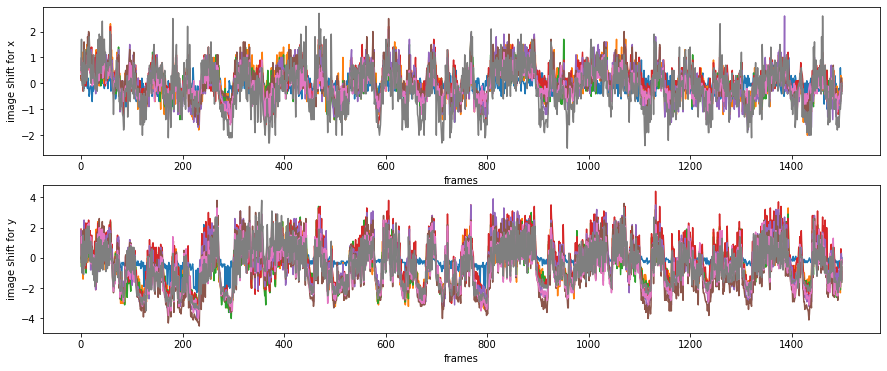

In [7]:
# If there are unreasonable shifts select "doFilter=True".
shiftvol = imp.computeMotionShift(imgStack, refVol, 10, 2, doFilter=False, stdFactor=4, showShiftFig=True)

#### Apply estimated motion to 4d stack
We assume here that all planes in a volume at a given time moved together

In [8]:
stack4dMCvol = imp.motionCorrection(imgStack, shiftvol)

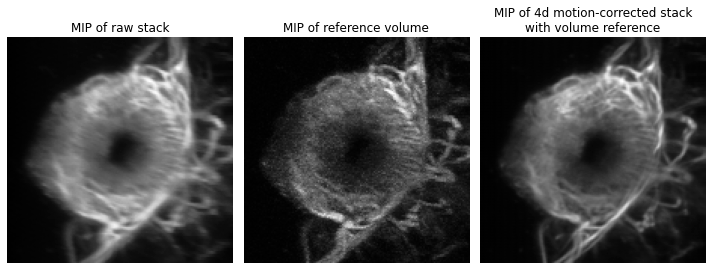

In [9]:
fig, axs = plt.subplots(1,3,figsize=(10,4))
cb = axs[0].imshow(stack.max(axis=1).mean(axis=0),cmap='Greys_r', origin='upper')
axs[0].set_title('MIP of raw stack')
axs[0].axis('off');
cb = axs[1].imshow(refVol.max(axis=0),cmap='Greys_r', origin='upper')
axs[1].set_title('MIP of reference volume')
axs[1].axis('off');
cb = axs[2].imshow(stack4dMCvol.max(axis=1).mean(axis=0),cmap='Greys_r', origin='upper')
axs[2].set_title('MIP of 4d motion-corrected stack\nwith volume reference')
axs[2].axis('off');
fig.tight_layout()
fig.savefig(saveDir+sep+'beforeAfterMotionCorrection_MIP_4d.pdf')

In [10]:
# Uncomment to look at motion corrected stack for quality control
#viewerdff1 = napari.view_image(stack4dMCvol)

### (3) Compute DFF

In [11]:
## Settings
# settings for Savitzky-Golay filter (default: 3rd order, 7 frames)
order = 3
window = 7

# Currently F_0 is estimated for each pixel on the whole time series (ok, if time series is short)
baseLinePercent = 10
offset = 0.0001

# Compute DFF
dffStack4d, stackF0vol = imp.computeDFF(stack4dMCvol, order, window, baseLinePercent, offset,baselineLowestMean=True)

processing 4d stack


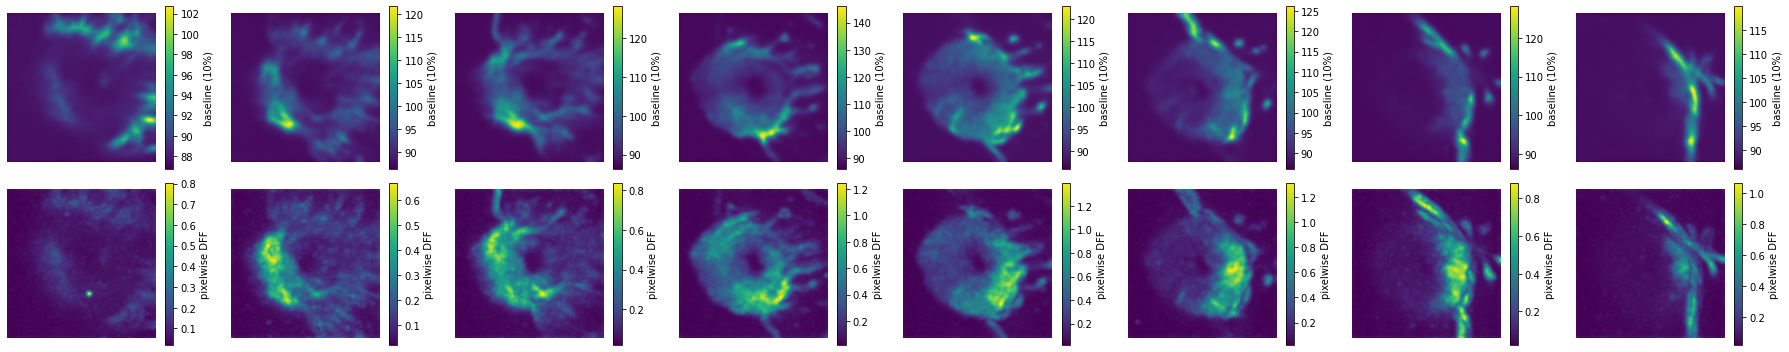

In [12]:
fig, ax = plt.subplots(2,stack4dMCvol["planes [µm]"].size,figsize=(25,5))
for i in range(stack4dMCvol["planes [µm]"].size):
    cb = ax[0,i].imshow(stackF0vol[i,:,:],cmap='viridis',origin='lower')#, vmin=0, vmax=10)
    plt.colorbar(cb, ax=ax[0,i], label='baseline ({}%)'.format(baseLinePercent))
    cb = ax[1,i].imshow(np.max(dffStack4d[:,i,:,:],axis=0),cmap='viridis',origin='lower')#, vmin=0, vmax=10)
    plt.colorbar(cb, ax=ax[1,i], label='pixelwise DFF')
    for a in ax[:,i]: a.axis('off')
    
fig.tight_layout()
fig.savefig(saveDir+sep+'F0andDFF_perPlane_4d.pdf')

In [13]:
dff4dXarray = imp.stack2xarray(dffStack4d, basicMetadat, data4D = True)
F0volXarray = imp.refStack2xarray(stackF0vol, basicMetadat, data4D = True)

In [14]:
# Uncomment to look at motion corrected stack for quality control
viewerdff1 = napari.view_image(dff4dXarray)

### (4) Save data
Data can be saved as data object (see preprocessImaging3D.ipynb for reference) or simply as arrays (see below).

In [22]:
savearrays = False
if savearrays:
    dff4dXarray.to_netcdf(sep.join([preprocDir, condition,'DFF4d.nc']), mode='w')
    np.save(sep.join([preprocDir, 'img', 'DFF4d.npy']),dffStack4d)
    F0volXarray.to_netcdf(sep.join([preprocDir, condition,'F0vol.nc']), mode='w')
    np.save(sep.join([preprocDir, 'img', 'F0vol.npy']),stackF0vol)
    np.save(sep.join([preprocDir, 'img', 'stack4dMC.npy']),stack4dMC)